In [38]:
import pandas as pd
import numpy as np
from parameter_estimator import ParameterEstimator as pe
import utils
from collections import deque
import cv2
import random
import math as m
from itertools import combinations
import pickle

def asspherical(x,y,z):
    r       =  m.sqrt(x*x + y*y + z*z)
    theta   =  m.acos(z/r)*180/ m.pi #to degrees
    phi     =  m.atan2(y,x)*180/ m.pi
    return r,theta,phi

v_asspherical = np.vectorize(asspherical)

def ascartesian(r, theta, phi):
    theta   = theta * m.pi/180 # to radian
    phi     = phi * m.pi/180
    x = r * m.sin( theta ) * m.cos( phi )
    y = r * m.sin( theta ) * m.sin( phi )
    z = r * m.cos( theta )
    return x, y, z

v_ascartesian = np.vectorize(ascartesian)

f_acin_colors = open('acin_colors.p', 'rb')
acin_colors = pickle.load(f_acin_colors)
f_acin_colors.close()
print(acin_colors.keys())

dict_keys(['acin_red', 'acin_gray', 'acin_yellow', 'acin_green', 'TU_blue', 'TU_gray', 'acin_red_complement', 'TU_blue_complement', 'acin_yellow_variant', 'acin_green_variant', 'acin_blue_variant', 'TU_green_variant', 'TU_pink_variant', 'TU_violet_variant'])


In [39]:
traj_file="/home/armin/catkin_ws/src/kident2/src/traj.csv"
try:
    df = pd.read_csv(traj_file)
except Exception as e:
    print(e)
traj = df.to_numpy()  # shape: (num_joints, num_traj_points)
traj = traj[:, 1:]  # delete header

In [40]:
dist_points = 0.03  # spacial resolution of trajectory at EE

In [41]:
observations = dict()
ids = list(range(30))
for marker_id in ids:
    observations[marker_id] = deque(maxlen=100) 
T_WMs = dict() 
for marker_id in ids:  # generate random poses for virtual markers
    r = np.random.normal(3, 0.12, 1)[0]
    theta = np.random.uniform(0, 90, 1)[0]
    phi   = np.random.uniform(0, 360, 1)[0]
    x, y, z = ascartesian(r, theta, phi)
    T_WMs[marker_id]= utils.H_rvec_tvec(np.array([0.0, 0, 0]), np.array([x, y, z]))

In [44]:
theta_all = pe.dhparams["theta_nom"]
d_all = pe.dhparams["d_nom"]
r_all = pe.dhparams["r_nom"]
alpha_all = pe.dhparams["alpha_nom"]

traj_ext=np.vstack((traj, np.zeros((1,120))))  # add a zero for the joint variable of the fixed camera joint

q = np.empty((8,0))


for q1, q2 in zip(traj_ext.T, traj_ext.T[1:]):   # all pairs of joint positions
    T_08_1 = pe.get_T_jk(0, 8, q1, theta_all, d_all, r_all, alpha_all)
    T_08_2 = pe.get_T_jk(0, 8, q2, theta_all, d_all, r_all, alpha_all)
    
    diff = T_08_1[0:3, 3] - T_08_2[0:3, 3]
    dist_total = np.linalg.norm(diff)
    num_steps = int(dist_total // dist_points)
    _q = np.array([np.linspace(q1_i, q2_i, num_steps) for q1_i, q2_i in zip(q1, q2)])
    q = np.hstack((q, _q))

In [45]:
print(np.shape(q))

(8, 2435)


In [46]:
T_W0 = np.array([[-1, 0, 0, 0],
                 [0, -1, 0, 0],
                 [0, 0, 1, 0.36],
                 [0, 0, 0, 1]])

T_corr = np.array([[ 0,  0, 1, 0],
                   [-1,  0, 0, 0],
                   [ 0, -1, 0, 0],
                   [ 0,  0, 0, 1]]) # euler [ x: -np.pi/2, y: np.pi/2, z: 0 ]

In [47]:
listkeys = list(T_WMs.keys())
print(f"list of keys: {listkeys}")

X = list()
Y = list()
Z = list()
Xm = list()
Ym = list()
Zm = list()

cntr = 0
for qi in q.T:
    T_WM_id = listkeys[0]
    cntr += 1
    if cntr == 30:
        cntr = 0
        listkeys = listkeys[1:]
        if len(listkeys) == 0:
            listkeys = list(T_WMs.keys())
            
    T_WM = T_WMs[T_WM_id]
    
    T_08_i = pe.get_T_jk(0, 8, qi, theta_all, d_all, r_all, alpha_all)
    T_W8_i = T_W0 @ T_08_i
    
    
    
    T_CM_i = np.linalg.inv(T_corr) @ np.linalg.inv(T_W8_i) @ T_WM @ np.linalg.inv(utils.Ry(-np.pi/2)) @ T_corr

    skew = 0.5 * (T_CM_i[0:3, 0:3] - T_CM_i[0:3, 0:3].T)
    
    obs = dict()
    obs['id'] = T_WM_id
#     rvec, _ = cv2.Rodrigues(T_CM_i[0:3, 0:3])
    rvec = np.array([skew[2, 1], skew[0, 2], skew[1, 0]])
    obs['rvec'] = list(rvec.flatten())
    obs['tvec'] = T_CM_i[0:3, 3]
    obs['t'] = 0
    obs['q'] = qi.flatten()
    
    observations[T_WM_id].append(obs)
    
    X.append(T_W8_i[0, 3])
    Y.append(T_W8_i[1, 3])
    Z.append(T_W8_i[2, 3])
    
    Xm.append((T_W8_i @ T_corr @ T_CM_i)[0, 3])
    Ym.append((T_W8_i @ T_corr @ T_CM_i)[1, 3])
    Zm.append((T_W8_i @ T_corr @ T_CM_i)[2, 3])

list of keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [48]:
import pickle
# open a file to store data
observations_file_str = "observations_fake2.p"
observations_file = open(observations_file_str, 'wb')
# dump information to that file
pickle.dump(observations, observations_file)
# close the file
observations_file.close()

# open a file to store data
# observations_file_str = "observations_fake_marker_pos.p"
# observations_file = open(observations_file_str, 'wb')
# dump information to that file
# pickle.dump(T_WMs, observations_file)
# close the file
# observations_file.close()
print("done")
print(len(observations[3]))

done
90


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


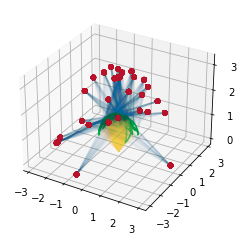

In [49]:
%matplotlib inline 
#%matplotlib widget
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.plot(X, Y, Z, c=acin_colors['acin_green'])
for x,y,z in zip(X,Y,Z):
    ax.plot([0,x], [0,y], [0,z], c=acin_colors['acin_yellow']+tuple([0.02]))
for x,y,z,xm,ym,zm in zip(X,Y,Z,Xm, Ym, Zm):
    ax.plot([xm,x], [ym,y], [zm,z], c=acin_colors['TU_blue']+tuple([0.01]))
ax.scatter(Xm, Ym, Zm, c=acin_colors['acin_red'])



In [50]:
#plt.savefig("ex10.pdf", format="pdf", bbox_inches="tight")

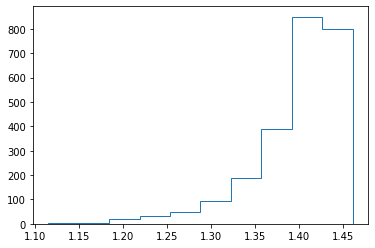

In [51]:
R, Theta, Phi = v_asspherical(X,Y,Z)

counts, bins = np.histogram(R)
plt.stairs(counts, bins)

In [52]:
acin_colors['acin_yellow']+tuple([0.2])

(0.9882352941176471, 0.8, 0.2784313725490196, 0.2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


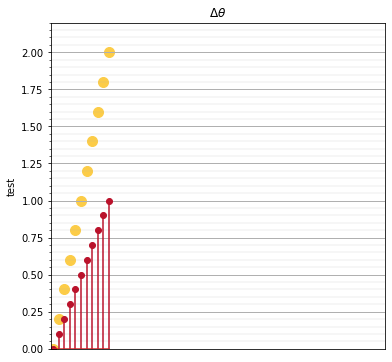

In [53]:
X = np.linspace(0,1,11)
Y = X
Z = [2*x for x in X]

fig_curr_est, ax_curr_est = plt.subplots(1, 1, figsize=(6, 6))
axis = np.array(ax_curr_est).reshape(1,1)
min = np.array(Z).min()*1.1
max = np.array(Z).max()*1.1
axis[0, 0].clear()
axis[0, 0].set_ylim([min, max])
axis[0, 0].scatter(X, Z, c=acin_colors['acin_yellow'], s=100)

axis[0, 0].set_title(r'$\Delta$$\theta$')
axis[0, 0].grid(which = "major", linewidth = 1)
axis[0, 0].grid(which = "minor", linewidth = 0.2)
axis[0, 0].minorticks_on()
markerline, stemlines, baseline = axis[0, 0].stem(X, Y)
plt.setp(markerline, 'color', acin_colors['acin_red'])
plt.setp(stemlines, 'color', acin_colors['acin_red'])
axis[0, 0].set_ylabel('test')
axis[0, 0].set_xticks([1,2,3,4,5,6])
axis[0, 0].set_xticks([])

plt.show()

In [54]:
arr = (np.random.rand(200)-np.ones(200)*0.5)*np.pi/180*4

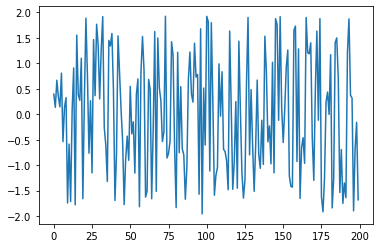

In [55]:
plt.plot(arr*180/np.pi)